In [1]:
from tqdm import tqdm_notebook as tqdm
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
class Q_net(nn.Module):
    def __init__(self):
        super(Q_net, self).__init__()
        self.fc1 = nn.Linear(2,8)
        self.fc2 = nn.Linear(8,15)
        self.fc5 = nn.Linear(15,3)
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x),0.1, True)
        x = F.leaky_relu(self.fc2(x),0.1, True)
        x = self.fc5(x)
        return x

In [26]:
def train_epoch(model, device, replay, optimizer):
    gamma=0.90
    losses=list()
    
    for i, (S_t,A_t,R_tp,S_tp) in enumerate(replay):
        # processing replay    
        #if j==0:
            #print('S_t,A_t,R_tp,S_tp:',S_t,A_t,R_tp,S_tp)
        _,V=e_greedy(S_tp,e=0)
        _,target_new=e_greedy(S_t,e=0)
        
        act_ind=np.int32(A_t.cpu().numpy()-1)
        
        if torch.all(torch.eq(target_new,V)):
            r=R_tp
        else:
            r=R_tp+gamma*V.max()
        target_new[act_ind]=r # only immediate
        
        if i==0:
            target=target_new
            s=torch.tensor(S_t,dtype=torch.float32)
            S=Variable(s,requires_grad=True)
            data=S
        else:
            s=torch.tensor(S_t,dtype=torch.float32)
            S=Variable(s,requires_grad=True)
            data=torch.cat((data,S))
            target=torch.cat((target,target_new))
    target=target.view(i+1,3)
    data=data.view(i+1,2)
    if i+1>30:
        #print('Batch Size',30)
        target=target[-31:-1,:]
        data=data[-31:-1,:]
    #else:
        #print('Batch Size',i+1)
    model.train()
    for j in range(1):
        # train        
        optimizer.zero_grad()
        output = model.forward(data)
        loss = F.mse_loss(output, target)
        #print(loss)
        losses.append(loss.item())
        loss.backward(retain_graph=True)
        optimizer.step()
    
    return losses


In [4]:
def setup(lr=1e-2):
    device = torch.device('cpu')
    model = Q_net().to(device)
    optimizer = optim.RMSprop(model.parameters(), lr=lr)
    return device, model, optimizer

In [5]:
def evaluate(d=10):
    d=d+1
    V_1=np.zeros([d,d])
    V_2=np.zeros([d,d])
    V_3=np.zeros([d,d])
    for i in range(d):
        for j in range(d):
            a,V=e_greedy([i,j],e=0)
            V_1[i,j]=V[0].item()
            V_2[i,j]=V[1].item()
            V_3[i,j]=V[2].item()
    maX=np.max([np.max(V_1),np.max(V_2),np.max(V_3)])
    Min=np.min([np.min(V_1),np.min(V_2),np.min(V_3)])
    
    #V_1=(V_1-Min)/(maX-Min)
    #V_2=(V_2-Min)/(maX-Min)
    #V_3=(V_3-Min)/(maX-Min)
    
    ax1=plt.subplot(2,2,1)    
    plt.imshow(V_1,cmap=plt.get_cmap('viridis'),
               vmin=Min, vmax=maX)   
    ax2=plt.subplot(2,2,2)    
    plt.imshow(V_2,cmap=plt.get_cmap('viridis'),
               vmin=Min, vmax=maX)
    ax3=plt.subplot(2,2,3)    
    plt.imshow(V_3,cmap=plt.get_cmap('viridis'), 
               vmin=Min, vmax=maX)

In [6]:
def e_greedy(S,e=1e-2):
    s=torch.tensor(S,dtype=torch.float32)
    S=Variable(s,requires_grad=True)

    V=model.forward(S)
    v,ind = V.max(0)
    aa=[i for i, j in enumerate(V) if j == v]
    a=0
    if np.random.rand(1)<=1-e:
        if len(aa)==1:
            a=ind+1
        elif 0 in aa:
            a=1
        else:
            a=ind+1
    else:
        a=np.random.randint(1,4)
    a=torch.tensor(a,dtype=torch.float32)
    if np.isnan(a):
        print('NNNNNNNAn')
    return a,V

In [7]:
def Environment2(f=0.1,R_plus=1,R_minus=20,e=1e-2,max_toss=4000,c=1):
    model.eval()
    S_0=np.array([0,0])
    replay=[]
    coin=np.random.randint(2,4)
    #print('coin',coin)
    if coin==3:
        S_list=S_0
        i=0
        while i<max_toss:
            if i==0:
                a,_=e_greedy(S_list,e=e)
            else:
                a,_=e_greedy(S_list[-1,:],e=e)
            #print(a)
            i=i+1 
            if a!=1:
                if a==coin:
                    Reward=R_plus
                else:
                    Reward=-R_minus
                #print(S_list)
                if S_list.ndim==1:
                    replay.append([S_list,a,Reward,S_list])
                else:
                    replay.append([S_list[-1,:],a,Reward,S_list[-1,:]])
                break
            else:
                #rint(S_list)
                if np.random.rand(1)<1-f:
                    S_list=np.vstack((S_list,np.array([0,1])))
                    S_list[-1,:]=S_list[-1,:]+S_list[-2,:]
                else:
                    S_list=np.vstack((S_list,np.array([1,0])))
                    S_list[-1,:]=S_list[-1,:]+S_list[-2,:]
                Reward=-c
                if i==max_toss:
                    print("time out")
                    #Reward=-R_minus
                replay.append([S_list[-2,:],a,Reward,S_list[-1,:]])
    else:
        S_list=S_0
        i=0
        while i<max_toss:
            if i==0:
                a,_=e_greedy(S_list,e=e)
            else:
                a,_=e_greedy(S_list[-1,:],e=e)
            #print(a)
            i=i+1
            if a!=1:
                if a==coin:
                    Reward=R_plus
                else:
                    Reward=-R_minus
                if S_list.ndim==1:
                    replay.append([S_list,a,Reward,S_list])
                else:
                    replay.append([S_list[-1,:],a,Reward,S_list[-1,:]])  
                break
            else:
                #print(S_list)
                if np.random.rand(1)<1-f:
                    S_list=np.vstack((S_list,np.array([1,0])))
                    S_list[-1,:]=S_list[-1,:]+S_list[-2,:]
                else:
                    S_list=np.vstack((S_list,np.array([0,1])))
                    S_list[-1,:]=S_list[-1,:]+S_list[-2,:]
                Reward=-c
                if i==max_toss:
                    print("time out")
                    #Reward=-R_minus
                replay.append([S_list[-2,:],a,Reward,S_list[-1,:]])
    R=Reward/max((len(S_list)-1),1)
    for x in replay[:-1]:
        x[2]=-Reward/(len(S_list)-1)**2*(len(S_list)-2)     
    return replay,S_list,R

In [8]:
#replay,S_list=Environment2()
#print(replay,S_list)


In [9]:
#s=0
#for x in replay:
#    s=s+x[2]
#s

In [10]:
def Environment(f=0.1,R_plus=1,R_minus=20,e=1e-2,max_toss=4000):
    model.eval()
    S_0=np.array([0,0])
    replay=[]
    coin=np.random.randint(2,4)
    #print('coin',coin)
    if coin==3:
        S_list=S_0
        i=0
        while i<max_toss:
            if i==0:
                a,_=e_greedy(S_list,e=e)
            else:
                a,_=e_greedy(S_list[-1,:],e=e)
            #print(a)
            i=i+1 
            if a!=1:
                if a==coin:
                    Reward=R_plus/max((len(S_list)-1),1)
                else:
                    Reward=-R_minus/max((len(S_list)-1),1)
                #print(S_list)
                if S_list.ndim==1:
                    replay.append([S_list,a,Reward,S_list])
                else:
                    replay.append([S_list[-1,:],a,Reward,S_list[-1,:]])
                break
            else:
                #rint(S_list)
                if np.random.rand(1)<1-f:
                    S_list=np.vstack((S_list,np.array([0,1])))
                    S_list[-1,:]=S_list[-1,:]+S_list[-2,:]
                else:
                    S_list=np.vstack((S_list,np.array([1,0])))
                    S_list[-1,:]=S_list[-1,:]+S_list[-2,:]
                Reward=0
                if i==max_toss:
                    print("time out")
                    #Reward=-R_minus
                replay.append([S_list[-2,:],a,Reward,S_list[-1,:]])
    else:
        S_list=S_0
        i=0
        while i<max_toss:
            if i==0:
                a,_=e_greedy(S_list,e=e)
            else:
                a,_=e_greedy(S_list[-1,:],e=e)
            #print(a)
            i=i+1
            if a!=1:
                if a==coin:
                    Reward=R_plus/max((len(S_list)-1),1)
                else:
                    Reward=-R_minus/max((len(S_list)-1),1)
                if S_list.ndim==1:
                    replay.append([S_list,a,Reward,S_list])
                else:
                    replay.append([S_list[-1,:],a,Reward,S_list[-1,:]])  
                break
            else:
                #print(S_list)
                if np.random.rand(1)<1-f:
                    S_list=np.vstack((S_list,np.array([1,0])))
                    S_list[-1,:]=S_list[-1,:]+S_list[-2,:]
                else:
                    S_list=np.vstack((S_list,np.array([0,1])))
                    S_list[-1,:]=S_list[-1,:]+S_list[-2,:]
                Reward=0
                if i==max_toss:
                    print("time out")
                    #Reward=-R_minus
                replay.append([S_list[-2,:],a,Reward,S_list[-1,:]])

    return replay,S_list,Reward
                

In [11]:
device, model, optimizer=setup()
model.cpu()

Q_net(
  (fc1): Linear(in_features=2, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=10, bias=True)
  (fc5): Linear(in_features=10, out_features=3, bias=True)
)

In [53]:
N=5000
optimizer = optim.RMSprop(model.parameters(), lr=0.0005)
for epoch in tqdm(range(N)):
    epsilon=1-1*min(epoch/N/0.2,0.9)
    replay,_,_=Environment2(e=epsilon)
    epoch_losses = train_epoch(model, device, replay, optimizer)
    if epoch%100==0:
        print('epsilon=',epsilon)
        print(f"Average loss in epoch {epoch}: {np.mean(epoch_losses):.5f}")
        a_2,_=e_greedy([10,0],e=0)
        a_3,_=e_greedy([0,10],e=0)
        print(a_2.item(),a_3.item())
        if np.mean(epoch_losses)<=0.001 and (a_2.item()==2.0 and a_3.item()==3.0):
            print('Yeah!')
            torch.save(model, "C:/Users/YYC/Desktop/DQN_RLcoin/models/3_layer_MLP_"+str(epoch)+".pt")

C:\Users\YYC\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epsilon= 1.0
Average loss in epoch 0: 35.81483
2.0 3.0
epsilon= 0.9
Average loss in epoch 100: 5.05078
2.0 3.0
epsilon= 0.8
Average loss in epoch 200: 3.70967
1.0 3.0
epsilon= 0.7
Average loss in epoch 300: 5.20668
1.0 3.0
epsilon= 0.6000000000000001
Average loss in epoch 400: 0.04624
1.0 3.0
epsilon= 0.5
Average loss in epoch 500: 4.50261
2.0 3.0
epsilon= 0.4
Average loss in epoch 600: 0.07984
1.0 3.0
epsilon= 0.29999999999999993
Average loss in epoch 700: 0.06881
2.0 3.0
epsilon= 0.20000000000000007
Average loss in epoch 800: 0.05048
2.0 3.0
epsilon= 0.10000000000000009
Average loss in epoch 900: 0.05251
2.0 3.0
epsilon= 0.09999999999999998
Average loss in epoch 1000: 0.04928
2.0 3.0
epsilon= 0.09999999999999998
Average loss in epoch 1100: 0.05201
2.0 3.0
epsilon= 0.09999999999999998
Average loss in epoch 1200: 0.03849
2.0 3.0
epsilon= 0.09999999999999998
Average loss in epoch 1300: 0.05850
2.0 3.0
epsilon= 0.09999999999999998
Average loss in epoch 1400: 0.04364
2.0 3.0
epsilon= 0.09

No. 23800


C:\Users\YYC\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


<IPython.core.display.Javascript object>


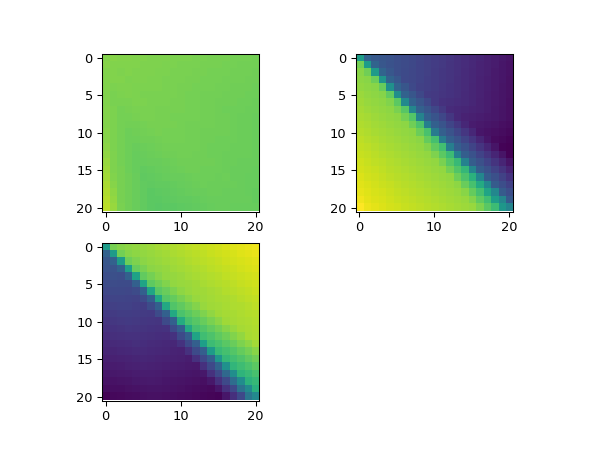

In [70]:
%matplotlib notebook
ev=1
if ev:
    ep=8800
    n=3
    model=torch.load("C:/Users/YYC/Desktop/DQN_RLcoin/models/betterthanMu.pt")
    print("No.",ep+N*n)
evaluate(d=20)
#3 is [0,1], 2 is [1,0] 


In [ ]:
R=list()
for i in tqdm(range(10000)):
    replay,S_list,Reward=Environment(e=0,max_toss=9999)
    R.append(Reward)
print("Evaluated Average Reward from Greedy policy of the Q net ",np.mean(R))

C:\Users\YYC\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [69]:
 torch.save(model, "C:/Users/YYC/Desktop/DQN_RLcoin/models/betterthanMu.pt")

C:\Users\YYC\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Q_net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [68]:
e_greedy([2,5],e=0)

C:\Users\YYC\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


(tensor(3.), tensor([  0.3694, -21.9386,   1.1973], grad_fn=<AddBackward0>))

In [ ]:
def pn(n,f=1/3):
    return 1/(1+((1-f)/f)**n)
    
for i in range(11):
    print("mu=",i," ",(1-pn(i))*1-pn(i)*20)